# General
- Baseline with naive solution Xresnet18
- Best Acc: 38.8

In [1]:
# import pkg_resources

# def placeholder(x):
#     raise pkg_resources.DistributionNotFound
# pkg_resources.get_distribution = placeholder

# !pip uninstall fastai fastcore torchaudio -y
# #!pip install torch==1.8.1 torchaudio==0.8.1 fastcore==1.3.20
# !pip install torch==1.9.0 torchaudio==0.9.0
# !pip install fastaudio

In [2]:
# try:
#     import pycaret
# except:
#     !pip install pycaret-nightly

In [3]:
import os
import librosa
from tqdm import tqdm

import pandas as pd
from fastaudio.all import *
from fastai.vision.all import *

import torch
import fastcore
import fastai
import torchaudio
torchaudio.set_audio_backend("sox_io")

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import plotly.express as px

from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings(action='ignore')

/home/kitemetric/anaconda3/envs/birdclef/lib/python3.8/site-packages/torchaudio/backend/utils.py:46: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  warnings.warn(
/home/kitemetric/anaconda3/envs/birdclef/lib/python3.8/site-packages/torchaudio/backend/utils.py:46: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  warnings.warn(


------------------------------------------------------
# EDA

In [4]:
# CONFIGURATIONS
DATA_DIR = Path('../../input/birdclef-2022/train_audio')

In [5]:
audio_fns = get_audio_files(DATA_DIR)
print(f'No. of audio files: {len(audio_fns)}')

# to save time, I subset training data
meta_df = pd.read_csv('../../input/birdclef-2022/train_metadata.csv')
test_df = pd.read_csv('../../input/birdclef-2022/test.csv')

No. of audio files: 14852


--------------------------------------------
# Analyzing Meta Data

In [6]:
meta_df.head().T.style.set_properties(**{'background-color': 'black',
                           'color': 'white',
                           'border-color': 'white'})

,0,1,2,3,4
primary_label,afrsil1,afrsil1,afrsil1,afrsil1,afrsil1
secondary_labels,[],"['houspa', 'redava', 'zebdov']",[],[],[]
type,"['call', 'flight call']",['call'],"['call', 'song']","['alarm call', 'call']",['flight call']
latitude,12.391000,19.880100,16.290100,17.092200,21.458100
longitude,-1.493000,-155.725400,-16.032100,54.295800,-157.725200
scientific_name,Euodice cantans,Euodice cantans,Euodice cantans,Euodice cantans,Euodice cantans
common_name,African Silverbill,African Silverbill,African Silverbill,African Silverbill,African Silverbill
author,Bram Piot,Dan Lane,Bram Piot,Oscar Campbell,Ross Gallardy
license,Creative Commons Attribution-NonCommercial-ShareAlike 3.0,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,Creative Commons Attribution-NonCommercial-ShareAlike 4.0,Creative Commons Attribution-NonCommercial-ShareAlike 4.0
rating,2.500000,3.500000,4.000000,4.000000,3.000000


In [7]:
train_df = meta_df.drop(['url','filename','scientific_name','license','time','common_name','secondary_labels']
                        ,axis=1
                        ,errors='ignore')
train_df = train_df.sample(1000)

In [8]:
enc_list = ['primary_label','author','type']
for feature in enc_list:
    le = LabelEncoder()
    le = le.fit(train_df[feature])
    train_df[feature] = le.transform(train_df[feature])

------------------------------------------------------------------------
# Understaning Metadata from the simple model

In [9]:
from pycaret.classification import *

In [10]:
setup(data = train_df, 
      target = 'primary_label',
      preprocess = True,
      silent = True
     )

,Description,Value
0,session_id,6077
1,Target,primary_label
2,Target Type,Multiclass
3,Label Encoded,None
4,Original Data,"(1000, 6)"
5,Missing Values,0
6,Numeric Features,5
7,Categorical Features,0
8,Ordinal Features,0
9,High Cardinality Features,0


([],
 {'acc': <pycaret.containers.metrics.classification.AccuracyMetricContainer at 0x7f343fe8a1f0>,
  'auc': <pycaret.containers.metrics.classification.ROCAUCMetricContainer at 0x7f343fe8a220>,
  'recall': <pycaret.containers.metrics.classification.RecallMetricContainer at 0x7f343fe8a2b0>,
  'precision': <pycaret.containers.metrics.classification.PrecisionMetricContainer at 0x7f343fe8a400>,
  'f1': <pycaret.containers.metrics.classification.F1MetricContainer at 0x7f343fe8a550>,
  'kappa': <pycaret.containers.metrics.classification.KappaMetricContainer at 0x7f343fe8a6a0>,
  'mcc': <pycaret.containers.metrics.classification.MCCMetricContainer at 0x7f343fe8a730>},
 Pipeline(memory=None, steps=[('empty_step', 'passthrough')], verbose=False),
 9754      68
 2232      17
 4549      32
 12716     98
 3952      30
         ... 
 7328      49
 12068     94
 14272    110
 5392      37
 1652      14
 Name: primary_label, Length: 1000, dtype: int64,
 False,
 {'lr': <pycaret.containers.models.clas

In [11]:
dt = create_model('dt',verbose = False)

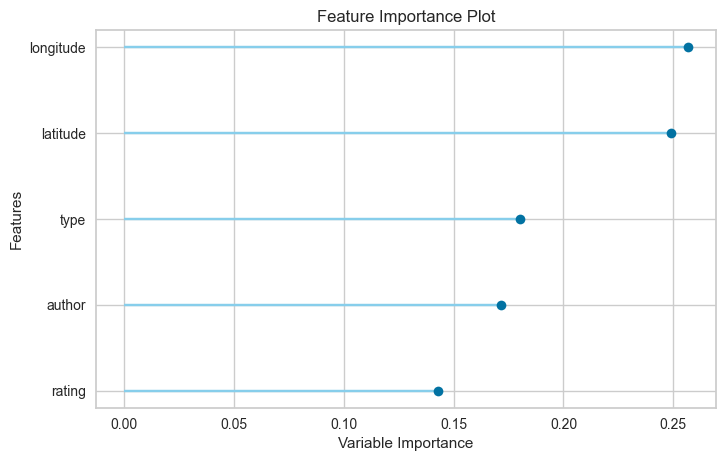

In [12]:
plot_model(dt, plot='feature')

------------------------------------
# Understanding Train Dataset

Train data are audio files. Let's hear it for ourselves and see the waveform to see what strategy can solve this problem.

In [13]:
def show_bird(audios):
    for fn in audios:
        audio = AudioTensor.create(fn)
        audio.show()

In [14]:
aud2mfcc = AudioToMFCC(n_mfcc=40, melkwargs={'n_fft':2048, 'hop_length':256,'n_mels':128})

## Making Pipeline

We build the pipeline in the following order.
> Resample -> DownmixMono -> RemoveSilence -> ResizeSignal -> AudioToMFCC -> Delta -> ToTensor

In [15]:
item_tfms = [RemoveSilence(),ResizeSignal(1000), aud2mfcc, Delta()]

In [16]:
aud_digit = DataBlock(blocks=(AudioBlock, CategoryBlock),  
                 get_items=get_audio_files, 
                 splitter=RandomSplitter(),
                 item_tfms = item_tfms,
                 get_y=parent_label)

In [17]:
aud_digit.summary(DATA_DIR)

Setting-up type transforms pipelines
Found 14852 items
2 datasets of sizes 11882,2970
Setting up Pipeline: partial
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: partial
    starting from
      ../../input/birdclef-2022/train_audio/mallar3/XC297303.ogg
    applying partial gives
      AudioTensor of size 1x418560
  Pipeline: parent_label -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      ../../input/birdclef-2022/train_audio/mallar3/XC297303.ogg
    applying parent_label gives
      mallar3
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(87)

Final sample: (AudioTensor([[-3.0518e-05,  0.0000e+00,  0.0000e+00,  ..., -3.0518e-05,
          0.0000e+00,  0.0000e+00]]), TensorCategory(87))


Found 14852 items
2 datasets of sizes 11882,2970
Setting up Pipeline: partial
Setting up Pipeline: parent_label -> Categorize -- {

In [18]:
dls = aud_digit.dataloaders(DATA_DIR, bs=16)

In [19]:
dls.c

152

<span style="color:Blue"> Observation:
    
* Target is composed of 152 classes.

--------------------------------------------------------------------
## Checking batch

<Figure size 720x576 with 0 Axes>

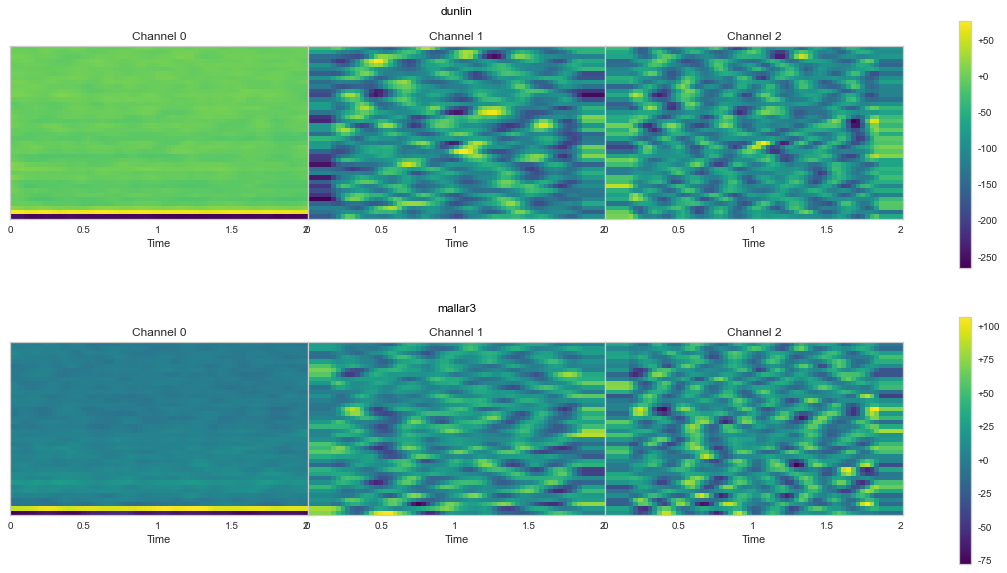

In [20]:
plt.figure(figsize=(10, 8))
dls.show_batch(max_n=3,figsize=(20,10))

------------------------------------------------------
# Modeling

In [21]:
def audio_learner(dls, arch, loss_func, metrics):
  "Prepares a `Learner` for audio processing"
  learn = Learner(dls, arch, loss_func, metrics=metrics, 
                  cbs = [EarlyStoppingCallback(monitor='accuracy', patience=5),ActivationStats(with_hist=True)]).to_fp16()
  n_c = dls.one_batch()[0].shape[1]
  if n_c == 1: alter_learner(learn)
  return learn

In [22]:
# from efficientnet_pytorch import EfficientNet
# model = EfficientNet.from_pretrained('efficientnet-b0')
# model._fc = nn.Linear(1280, dls.c)

learn = audio_learner(dls, 
                      xresnet18(), 
                      LabelSmoothingCrossEntropy(), 
                      accuracy)

SuggestedLRs(lr_min=0.19054607152938843, lr_steep=0.00363078061491251)

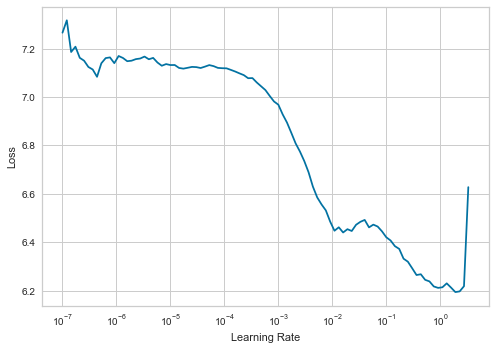

In [23]:
sr = learn.lr_find()
sr

------------------------------------------------
# Training

In [24]:
learn.fit_one_cycle(10, sr.lr_steep)

epoch,train_loss,valid_loss,accuracy,time
0,4.574412,4.723834,0.115152,04:48
1,4.362818,4.637516,0.132660,04:56
2,4.135171,4.217168,0.201010,04:38
3,3.970837,4.027332,0.241751,04:40
4,3.744967,3.998763,0.253535,04:51
5,3.575875,3.770216,0.302020,04:42
6,3.480796,3.617463,0.340404,04:43
7,3.380949,3.572118,0.344781,04:37
8,3.370722,3.559389,0.359933,05:08
9,3.290123,3.550770,0.359259,04:49


/home/kitemetric/anaconda3/envs/birdclef/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kitemetric/anaconda3/envs/birdclef/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kitemetric/anaconda3/envs/birdclef/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kitemetric/anaconda3/envs/

-------------------------------------------
# Interpreting Model

In [25]:
def plot_layer_stats(self, idx):
    plt,axs = subplots(1, 3, figsize=(15,3))
    plt.subplots_adjust(wspace=0.5)
    for o,ax,title in zip(self.layer_stats(idx),axs,('mean','std','% near zero')):
        ax.plot(o)
        ax.set_title(title)

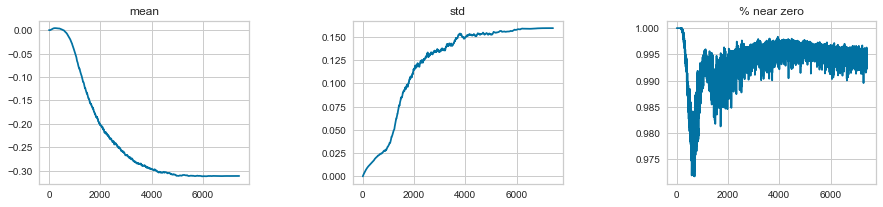

In [26]:
plot_layer_stats(learn.activation_stats,-2)

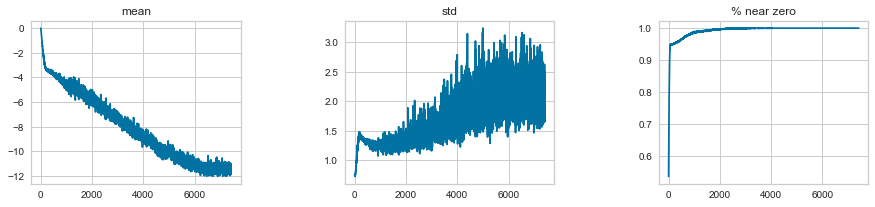

In [27]:
plot_layer_stats(learn.activation_stats,-1)

<span style="color:Blue"> Observation:
* The activation distribution is well distributed.

learn.save('stage-1')

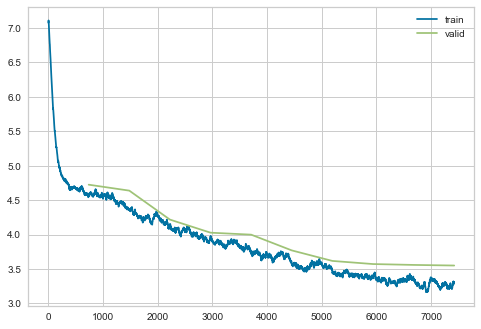

In [28]:
learn.recorder.plot_loss()

<span style="color:Blue"> Observation:
* It seems that learning has ended before overffing. However, I still don't know if it is the optimal point. It is burdensome to increase the epoch because the training time is too long.

----------------------------------------------
# Checking Results

<span style="color:Blue"> Observation:
* Because there are many classes of Target, it is not good to look at.
* If you look at the diagonal of the matrix, it seems that it has learned to some extent. However, it is not satisfactory.

**Let's check the cases where the model made the most mistakes!**

In [30]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=10)

[('brnowl', 'bcnher', 16),
 ('bcnher', 'brnowl', 15),
 ('houfin', 'norcar', 11),
 ('rudtur', 'dunlin', 10)]

<span style="color:Blue"> Observation:
* In the combination of 'bcnher' and 'brnowl', there are many cases where the judgment is exceptionally wrong. I guess I'll have to check more on why. 

# Unfreeze and retrain model

In [31]:
learn.unfreeze()

In [33]:
learn.fit_one_cycle(10, sr.lr_steep)

epoch,train_loss,valid_loss,accuracy,time
0,3.254294,3.518477,0.363300,05:00
1,3.159925,3.524372,0.368350,05:18
2,3.226796,3.531204,0.376094,04:56
3,3.197299,3.513385,0.369697,05:08
4,3.148704,3.575704,0.363300,05:05
5,3.190275,3.487633,0.388889,04:55
6,3.180172,3.472829,0.382155,05:06
7,3.160499,3.507531,0.373737,05:06
8,3.085646,3.517249,0.372391,05:00
9,3.171831,3.484553,0.377778,05:10
